If Dockerfiles have not been modified, connect to the Jupyter server with ```http://localhost:8015/tree?token=sketchbook```.  

This notebook provides an interface to draw graphics. It is not intended as a data pipeline.  

In [1]:
import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pyproj import Transformer
import seaborn as sns
import scipy
import sklearn
import skimage as ski

import csv
import json
import math
import os
from pathlib import Path

In [5]:
alpha = 1
top_left = (116.538, 82.810)
bot_right = (768.072, 867.343)
resize = 0.9

def scale_df_column(df, column):
    lower = df[column].min()
    upper = df[column].max()
    d = upper - lower
    new_df = df.copy()
    new_df[f"{column}_scaled"] = new_df.apply(lambda x: (x[column] - lower) / d, axis=1)
    return new_df

def morphology_marker(i):
    markers = ['o', 'v', '^', 's', 'p', '*', 'h', 'd', 'P', 'X']
    return markers[i]

def perception_colour(i):
    colours = ["#914e72", "#3255a4", "#00a95c", "#f15060", "#765ba7", "#407060", "#bb8b41", "#ffe800", "#ff48b0"]
    return colours[i]

image = cv2.imread("data/shunfu_gray.png")
width = abs(bot_right[1] - top_left[1])
height = abs(bot_right[0] - top_left[0])
image_height, image_width, _ = np.array(image).shape
transformer = Transformer.from_crs(4326, 3414, always_xy=True)
geographical_pos = {}
with open("data/shunfu-id.csv", 'r') as fp:
    reader = csv.reader(fp)
    next(reader)
    for row in reader:
        geographical_pos[row[0]] = transformer.transform(row[2], row[1])
geographical_df = pd.DataFrame.from_dict(geographical_pos, orient="index", columns=["x", "y"])
geographical_df = scale_df_column(scale_df_column(geographical_df, "x"), "y")
with open("data/shunfu-clustering/shunfu-segmented-point-clouds-combined-encoded_clustering.csv", 'r') as fp:
    morphology_df = pd.read_csv(fp, index_col=0)
morphology_df = scale_df_column(scale_df_column(morphology_df, "x"), "y")
with open("data/shunfu-clustering/shunfu-perceptions_clustering.csv", 'r') as fp:
    perception_df = pd.read_csv(fp, index_col=0)
perception_df = scale_df_column(scale_df_column(perception_df, "x"), "y")
# cluster_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")
map_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")
map_df = geographical_df.join(map_df, how="inner")
map_df["morphology_marker"] = map_df.apply(lambda df: morphology_marker(int(df["cluster_morphology"])), axis=1)
map_df["perception_colour"] = map_df.apply(lambda df: perception_colour(int(df["cluster_perception"])), axis=1)

# map_df["x_target"] = map_df.apply(lambda df: (alpha * ((df["x_scaled_morphology"] + df["x_scaled_perception"]) / 2) + (1 - alpha) * df["x_scaled"]), axis=1)
# map_df["y_target"] = map_df.apply(lambda df: (alpha * ((df["y_scaled_morphology"] + df["y_scaled_perception"]) / 2) + (1 - alpha) * df["y_scaled"]), axis=1)
# map_df["x_target"] = map_df.apply(lambda df: (alpha * (df["x_scaled_morphology"]) + (1 - alpha) * df["x_scaled"]), axis=1)
# map_df["y_target"] = map_df.apply(lambda df: (alpha * (df["y_scaled_morphology"]) + (1 - alpha) * df["y_scaled"]), axis=1)
map_df["x_target"] = map_df.apply(lambda df: (alpha * (df["x_scaled_perception"]) + (1 - alpha) * df["x_scaled"]), axis=1)
map_df["y_target"] = map_df.apply(lambda df: (alpha * (df["y_scaled_perception"]) + (1 - alpha) * df["y_scaled"]), axis=1)


image = cv2.resize(image, (round(image_height * resize), round(image_width * resize)))
map_df["x_image_source"] = (map_df["x_scaled"] * width + top_left[0]) * resize
map_df["y_image_source"] = ((1 - map_df["y_scaled"]) * height + top_left[1]) * resize
map_df["x_image_target"] = (map_df["x_target"] * width + top_left[0]) * resize
map_df["y_image_target"] = ((1 - map_df["y_target"]) * height + top_left[1])
# map_df = map_df.drop(map_df[map_df.cluster_morphology != 9].index)
# map_df = map_df.drop(map_df[map_df.cluster_perception != 8].index)

source = map_df[["x_image_source", "y_image_source"]].to_numpy()
target = map_df[["x_image_target", "y_image_target"]].to_numpy()

src = source
dst = target

# Estimate the TPS transformation from these points and then warp the image.
# We switch `src` and `dst` here because `skimage.transform.warp` requires the
# inverse transformation!
# tps = ski.transform.ThinPlateSplineTransform()
# tps.estimate(dst, src)
# warped = ski.transform.warp(image, tps, order=0)

# # Plot the results
fig, axs = plt.subplots(figsize=(image_width * resize / 20, image_height * resize / 20), dpi=300)

# axs = sns.scatterplot(data=map_df, x="x_image_source", y="y_image_source", s=150,
#                 style="cluster_morphology", markers={0: 'o', 1:'v', 2: '^', 3: 's', 4: 'p', 5: '*', 6: 'h', 7: 'd', 8: 'P', 9: 'X'},
#                 hue="cluster_perception", palette={0: "#914e72", 1: "#3255a4", 2: "#00a95c", 3: "#f15060", 4: "#765ba7", 5: "#407060", 6: "#bb8b41", 7: "#ffe800", 8: "#ff48b0"})
# sns.move_legend(axs, "lower left", bbox_to_anchor=(1, 0), fontsize=15, labels=["Perception cluster", 1,2,3,4,5,6,7,8,9, "Morphology Cluster", 1,2,3,4,5,6,7,8,9,10])
# axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
# axs.imshow(image, alpha=0.75)

# axs = sns.scatterplot(data=map_df, x="x_image_target", y="y_image_target", s=150,
#                 style="cluster_morphology", markers={0: 'o', 1:'v', 2: '^', 3: 's', 4: 'p', 5: '*', 6: 'h', 7: 'd', 8: 'P', 9: 'X'},
#                 hue="cluster_perception", palette={0: "#914e72", 1: "#3255a4", 2: "#00a95c", 3: "#f15060", 4: "#765ba7", 5: "#407060", 6: "#bb8b41", 7: "#ffe800", 8: "#ff48b0"})
# sns.move_legend(axs, "lower left", bbox_to_anchor=(1, 0), fontsize=15, labels=["Perception cluster", 1,2,3,4,5,6,7,8,9, "Morphology Cluster", 1,2,3,4,5,6,7,8,9,10])
# axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
# axs.imshow(warped, alpha=0.75)

# axs = sns.scatterplot(data=map_df, x="x_image_target", y="y_image_target", s=150, color="black",
#                 style="cluster_morphology", markers={0: 'o', 1:'v', 2: '^', 3: 's', 4: 'p', 5: '*', 6: 'h', 7: 'd', 8: 'P', 9: 'X'})
# sns.move_legend(axs, "lower left", bbox_to_anchor=(1, 0), fontsize=15)
# axs.set_aspect("equal")
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)
# axs.set_ylim(axs.get_ylim()[::-1])

axs = sns.scatterplot(data=map_df, x="x_image_target", y="y_image_target", s=150, style='x',
                hue="cluster_perception", palette={0: "#914e72", 1: "#3255a4", 2: "#00a95c", 3: "#f15060", 4: "#765ba7", 5: "#407060", 6: "#bb8b41", 7: "#ffe800", 8: "#ff48b0"})
plt.legend([], [], frameon=False)
axs.set_aspect("equal")
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
axs.set_ylim(axs.get_ylim()[::-1])

Path("data/shunfu-warped").mkdir(parents=True, exist_ok=True)
with open(os.path.join("data/shunfu-warped", f"tsne_perception_surrogate.png"), 'wb') as fp:
    plt.savefig(fp, transparent=True, bbox_inches="tight", pad_inches=0)
# Image.fromarray(warped).save(os.path.join(f"data/shunfu-warped/perception_8_{alpha}.png"))

In [8]:
print(image_height)

1023


In [ ]:
target_dir = "data"
input_dir = "shunfu-perceptions"

datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index')
datas_df.index.name = "id"

with open("data/shunfu-id.csv", 'r') as fp:
    locations = pd.read_csv(fp, index_col=0)
locations = locations.drop_duplicates()
perceptions = datas_df.join(locations[["lat", "lon"]], how="inner")
perceptions.to_csv("data/perceptions.csv")

In [ ]:
target_dir = "data"
input_dir = "shunfu-segmented-point-clouds-combined-encoded"
models_dir = "shunfu-clustering"
cluster_no = 9

datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index')

with open(os.path.join(target_dir, models_dir, "shunfu-segmented-point-clouds-combined-encoded_scaler.pkl"), "rb") as fp:
    scaler = joblib.load(fp)
with open(os.path.join(target_dir, models_dir, "shunfu-segmented-point-clouds-combined-encoded_pca.pkl"), "rb") as fp:
    pca = joblib.load(fp)
with open(os.path.join(target_dir, models_dir, "shunfu-segmented-point-clouds-combined-encoded_kmeans.pkl"), "rb") as fp:
    kmeans = joblib.load(fp)
with open(os.path.join(target_dir, models_dir, "shunfu-segmented-point-clouds-combined-encoded_clustering.csv"), 'r') as fp:
    point_clouds_df = pd.read_csv(fp, index_col=0)

cluster_df = datas_df.loc[datas_df.index.isin(point_clouds_df.loc[point_clouds_df["cluster"] == 0].index)]
dist_to_centre = np.linalg.norm(kmeans.transform(pca.transform(scaler.transform(cluster_df.values))) - kmeans.transform(kmeans.cluster_centers_[cluster_no].reshape(1, pca.components_.shape[0])), axis=1)
cluster_with_dist_df = pd.DataFrame(dist_to_centre, index=cluster_df.index, columns=["dist_to_centre"]).sort_values(by="dist_to_centre", ascending=True)
top_8 = cluster_with_dist_df.head(8).index
print(top_8)

In [ ]:
target_dir = "data"
cluster_csv = "shunfu-clustering/shunfu-perceptions_clustering.csv"
input_dir = "shunfu-perceptions"
output_dir = "shunfu-clustering"

datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index')

with open(os.path.join(target_dir, cluster_csv), 'r') as fp:
    cluster_df = pd.read_csv(fp, index_col=0)

df = datas_df.join(cluster_df["cluster"], how="inner")
cluster_perceptions = df.groupby(by="cluster").mean()

categories = cluster_perceptions.columns


colours = ["#914e72", "#3255a4", "#00a95c", "#f15060", "#765ba7", "#407060", "#bb8b41", "#ffe800", "#ff48b0"]
j = 0
for row in cluster_perceptions.itertuples():
    print(row[0])
    values = row[1:]
    # The radar chart needs to be closed, so append the first value at the end of the values list
    values += values[:1]
    print(values)
    num_categories = len(categories)
    # Create angles for each axis (equally spaced around the circle)
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    angles += angles[:1]
    # Create the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), dpi=300)
    # Set the labels for each category
    ax.set_xticks(angles[:-1])  # Remove the last angle (duplicate of the first)
    ax.set_xticklabels(categories)
    ax.set_ylim(23, 28)
    for i, label in enumerate(ax.get_xticklabels()):
        angle = angles[i]
        if angle > np.pi / 2 and angle < 3 * np.pi / 2:  # Categories on the left half
            label.set_horizontalalignment('right')
        else:  # Categories on the right half
            label.set_horizontalalignment('left')
        # Adjust vertical alignment if necessary
        label.set_verticalalignment('center')
    # Plot the data
    ax.plot(angles, values, linewidth=0, linestyle='solid')

    # Fill the area under the plot
    ax.fill(angles, values, alpha=1, color=colours[j])

    # Show the plot
    with open(os.path.join(target_dir, output_dir, f"perception_cluster_{row[0]}.png"), 'wb') as fp:
        plt.savefig(fp, transparent=True, bbox_inches="tight", pad_inches=0)
    plt.cla()
    # plt.show()
    j += 1    

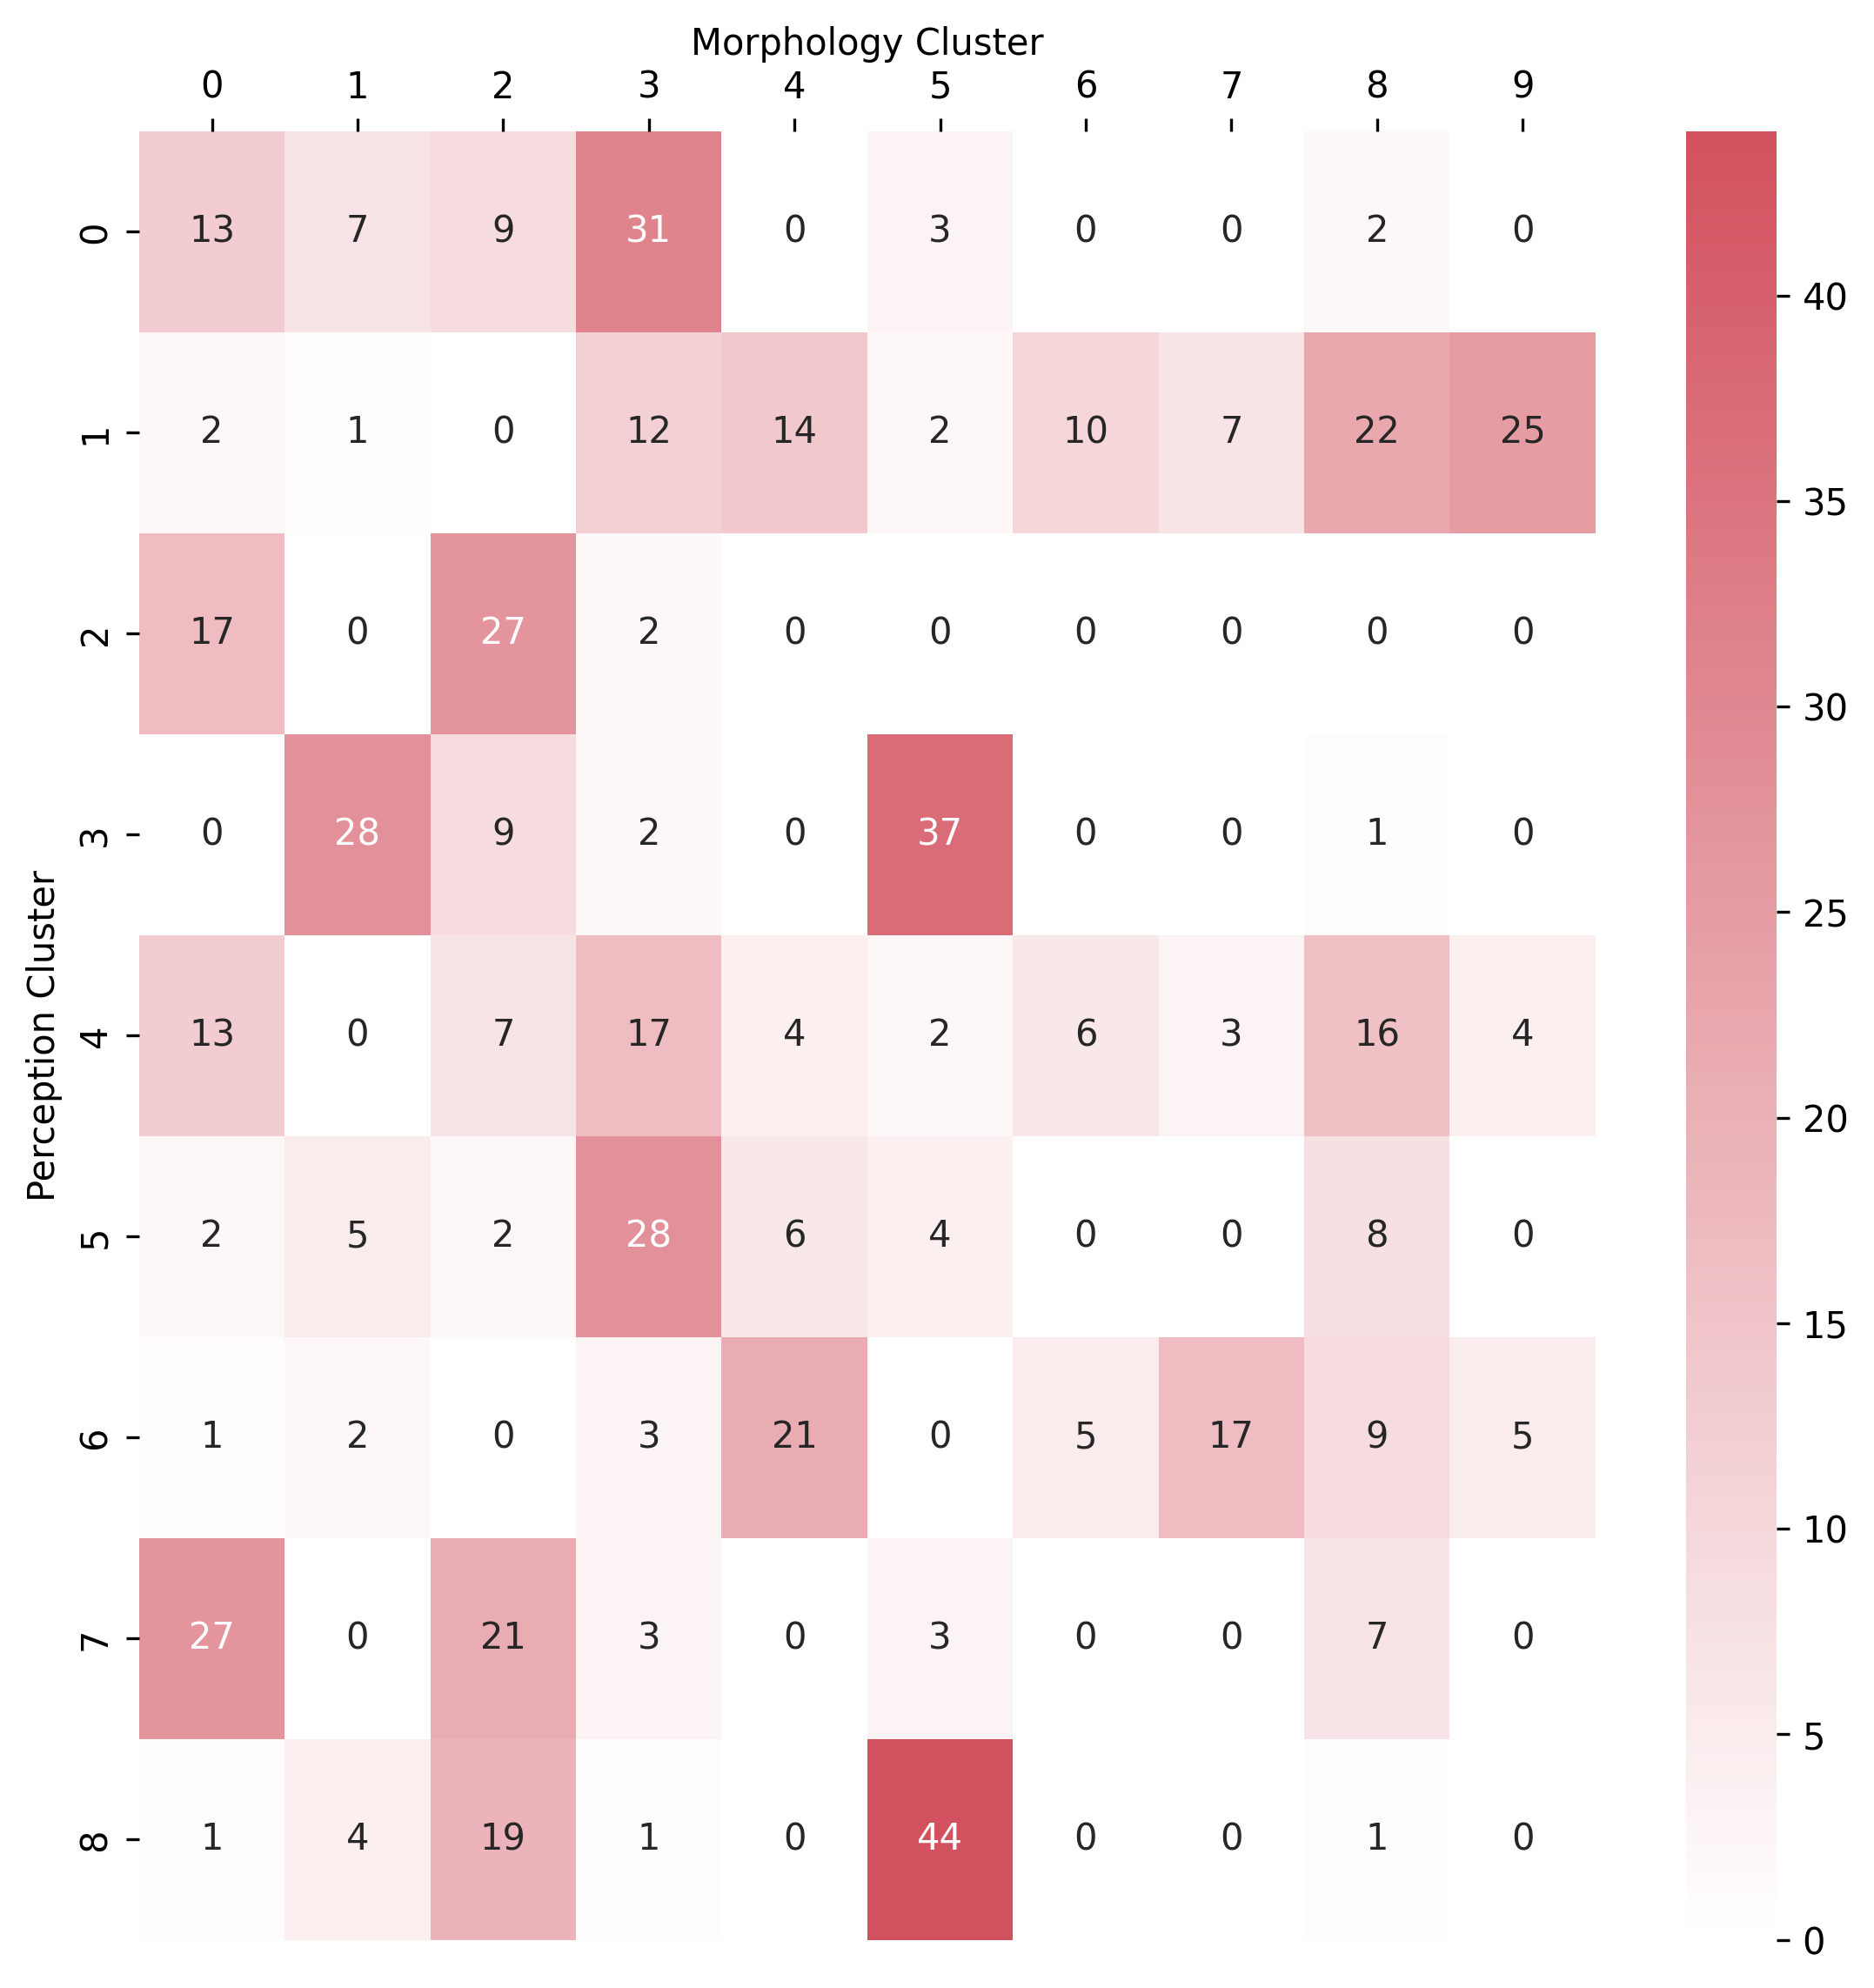

In [61]:
from matplotlib.colors import LinearSegmentedColormap

target_dir = "data"
morphology_csv = "shunfu-clustering/shunfu-segmented-point-clouds-combined-encoded_clustering.csv"
perception_csv = "shunfu-clustering/shunfu-perceptions_clustering.csv"

with open(os.path.join(target_dir, morphology_csv), 'r') as fp:
    morphology_df = pd.read_csv(fp, index_col=0)
with open(os.path.join(target_dir, perception_csv), 'r') as fp:
    perception_df = pd.read_csv(fp, index_col=0)
cluster_df = morphology_df.join(perception_df, how="inner", lsuffix="_morphology", rsuffix="_perception")

cmap = LinearSegmentedColormap.from_list('bright_red', ["#ffffff", "#d2515e"])
fig, ax = plt.subplots(figsize=(9, 9), dpi=300)
ax = sns.heatmap(pd.crosstab(cluster_df["cluster_perception"], cluster_df["cluster_morphology"]),
            annot=True, cmap=cmap)
ax.set(xlabel="Morphology Cluster", ylabel="Perception Cluster")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
with open(os.path.join(target_dir, "shunfu-clustering", f"cluster_histogram.png"), 'wb') as fp:
    plt.savefig(fp, transparent=True, bbox_inches="tight", pad_inches=0)

In [65]:
geographical_df

,x,y,x_scaled,y_scaled
FXIXGaU7RhpONtOed0zeFw,28176.919273,37255.692473,0.037132,0.609212
uay8-87UCbbgLe4gviaObg,28159.938587,37229.914451,0.014570,0.580534
YDYwtmmNmawTNcWxnMlM5g,28197.463540,37178.649870,0.064429,0.523501
eb5pYTdA_6sdCyasW1oeYw,28148.972513,37223.469235,0.000000,0.573363
kN58saRVuTAHP-0ZMG-K6A,28201.164842,37188.640321,0.069346,0.534616
...,...,...,...,...
VJTtnkeAdnhM-YCFqlbXrg,28863.979022,37358.461445,0.950009,0.723544
wKbIl4WFpC09xoN0RO2xGw,28638.793036,36732.345435,0.650811,0.026980
YrSs3cIEG-sEw3chOtuwEw,28489.693347,36743.736292,0.452706,0.039653
zjix4uDXzakxWnFu6D6_tw,28870.988033,37407.128638,0.959322,0.777687
